# XGBoost
## 1. 모델 소개
---
XGBoost (Extreme Gradient Boosting) 는 2016년 Tianqi Chen이 개발한 그래디언트 부스팅(Gradient Boosting) 프레임워크입니다. 기존 부스팅 모델의 학습 속도, 메모리 효율, 일반화 성능을 극대화하도록 설계되어, 캐글(Kaggle) 등 데이터 분석 대회에서 가장 많이 사용되는 모델 중 하나입니다.
## 2. 주요 특징
---
### Regularized Objective Function (정규화 목적함수)
일반 그레이디언트 부스팅과 달리 XGBoost는 학습 목표의 일부로 정규화를 포함합니다.    

이로써 과적합(Overfitting) 방지와 모델의 일반화 성능 향상을 동시에 달성합니다.
### Sparsity-aware Algorithm (희소 데이터 최적화)
XGBoost는 결측치(missing value) 또는 희소(sparse) 데이터에서도 효율적으로 동작하도록‘Sparsity-aware Split Finding Algorithm’을 도입했습니다.  
- 각 노드에서 결측값을 왼쪽/오른쪽 중 어느 쪽으로 보낼지 자동 학습
- 데이터가 희소할수록 연산량이 줄어들며, dense한 모델보다 빠른 학습 속도를 달성
### Parallel & Distributed Learning (병렬 및 분산 학습)
XGBoost는 CPU 멀티스레딩을 활용한 병렬 학습(Parallel learning) 과
클러스터 기반의 분산 학습(Distributed learning) 을 모두 지원합니다.

- Column Block 구조로 각 피처별 정렬을 사전 수행 → 분할 탐색을 선형 시간에 처리

- Cache-aware Access 를 적용하여 CPU 캐시 미스(Cache miss)를 최소화

- Out-of-core Computing: 디스크에 데이터를 나눠 저장하고, 압축·샤딩을 통해 메모리를 초과하는 대용량 데이터도 학습 가능
## 3. 참고 자료
---
- 논문: XGBoost: A Scalable Tree Boosting System
- 저자: Tianqi Chen, Carlos Guestrin
- 학회: KDD 2016 (The 22nd ACM SIGKDD Conference on Knowledge Discovery and Data Mining)
- 논문 링크: https://dl.acm.org/doi/10.1145/2939672.2939785

In [1]:
# library & install
from google.colab import drive
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

## Load data

In [10]:
import sys
import os

# Specify the path to the directory containing data_load.py
# Make sure this path is correct and accessible from your Colab environment
data_load_path = '/content/drive/MyDrive/utils'

# Add the directory to sys.path to allow importing modules from it
sys.path.append(data_load_path)

try:
    # Import the data_load module
    import data_load

    # Now you can use functions from the data_load module, for example:
    # from data_load import your_function_name
    # your_function_name()

    print("Successfully imported data_load.py")

except ImportError as e:
    print(f"Error importing data_load.py: {e}")
    print(f"Please ensure data_load.py exists at {os.path.join(data_load_path, 'data_load.py')} and the file name is correct.")

combined_df = data_load.load_data(start_date='2025-01-01', end_date='2025-09-14')

Successfully imported data_load.py
🔍 ['2025-01-01'부터 '2025-09-14'까지의 데이터를 로드]


/content/drive/MyDrive/utils/data_load.py:48: DtypeWarning: Columns (19,20,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(
/content/drive/MyDrive/utils/data_load.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(dfs_to_concat, ignore_index=True)



✅ 총 257개 파일, 8474140개 행의 데이터를 성공적으로 합쳤습니다.


## Data preprocessing

In [4]:
# Specify the path to the directory containing preprocessor.py
# Make sure this path is correct and accessible from your Colab environment
preprocessor_path = '/content/drive/MyDrive/utils'

# Add the directory to sys.path to allow importing modules from it
sys.path.append(preprocessor_path)

try:
    # Import the preprocessor module
    import preprocessor

    # Now you can use functions from the preprocessor module, for example:
    # from preprocessor import your_function_name
    # your_function_name()

    print("Successfully imported preprocessor.py")

except ImportError as e:
    print(f"Error importing preprocessor.py: {e}")
    print(f"Please ensure preprocessor.py exists at {os.path.join(preprocessor_path, 'preprocessor.py')} and the file name is correct.")

Successfully imported preprocessor.py


In [5]:
print("--- 데이터 전처리 시작 ---")

# Identify columns that are currently of object type
object_cols = combined_df.select_dtypes(include=['object']).columns

# Convert all values in object columns to string type to ensure uniform input for potential LabelEncoding within preprocessor.py
for col in object_cols:
    combined_df[col] = combined_df[col].astype(str)
    print(f"✅ 컬럼 '{col}'을(를) 문자열 타입으로 변환 완료")

# Call the preprocessor function from the imported module
# During the preprocessing, LabelEncoder works correctly only if the input data types are all the same.
# Therefore, identify all columns with dtype 'object' within the DataFrame and unify them to string (str) type
# to prevent errors due to mixed types (TypeError: '<' not supported between instances of 'int' and 'str').
combined_df = preprocessor.preprocessor(combined_df)

--- 데이터 전처리 시작 ---
✅ 컬럼 '생성일'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '급수펌프 입력'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '배기가스온도2'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '배기가스온도3'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '배기 재 순환 온도'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '에코 온도1'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '에코 온도2'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '버너온도'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '재순환 O2'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '재순환 NOx'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '운전시간'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '확률 업데이트 시간'을(를) 문자열 타입으로 변환 완료
--- 데이터 전처리 시작 ---
✅ 1. 불필요한 컬럼 14개 제거 완료
✅ 2-1. 범주형 데이터 결측치 처리 완료
✅ 2-2. 범주형 변수 변환 완료
ℹ️ 2-3. 처리할 수치형 결측치가 없습니다.
✅ 3. 피처 스케일링 완료
--- 데이터 전처리 완료 ---


## Data Visualization

부하율             float64
설정 압력           float64
보일러 압력          float64
송풍기 인버터 출력      float64
송풍기 입력          float64
급수 펌프           float64
급수펌프 입력         float64
가스 댐퍼           float64
가스 댐퍼 입력        float64
Air 댐퍼          float64
Air 댐퍼 입력       float64
재순환 댐퍼          float64
재순환 외기 댐퍼       float64
재순환 댐퍼 입력       float64
재순환 외기 댐퍼 입력    float64
급수 수위           float64
보일러 온도          float64
배기가스온도1         float64
배기가스온도2         float64
배기가스온도3         float64
배기 재 순환 온도      float64
에코 온도1          float64
에코 온도2          float64
버너온도            float64
배기가스 NOx        float64
배기가스 O2         float64
재순환 O2          float64
재순환 NOx         float64
급수량(적산유량)       float64
급수량(순간유량)       float64
연료량(적산유량)       float64
연료량(순간유량)       float64
효율(순간)          float64
dtype: object


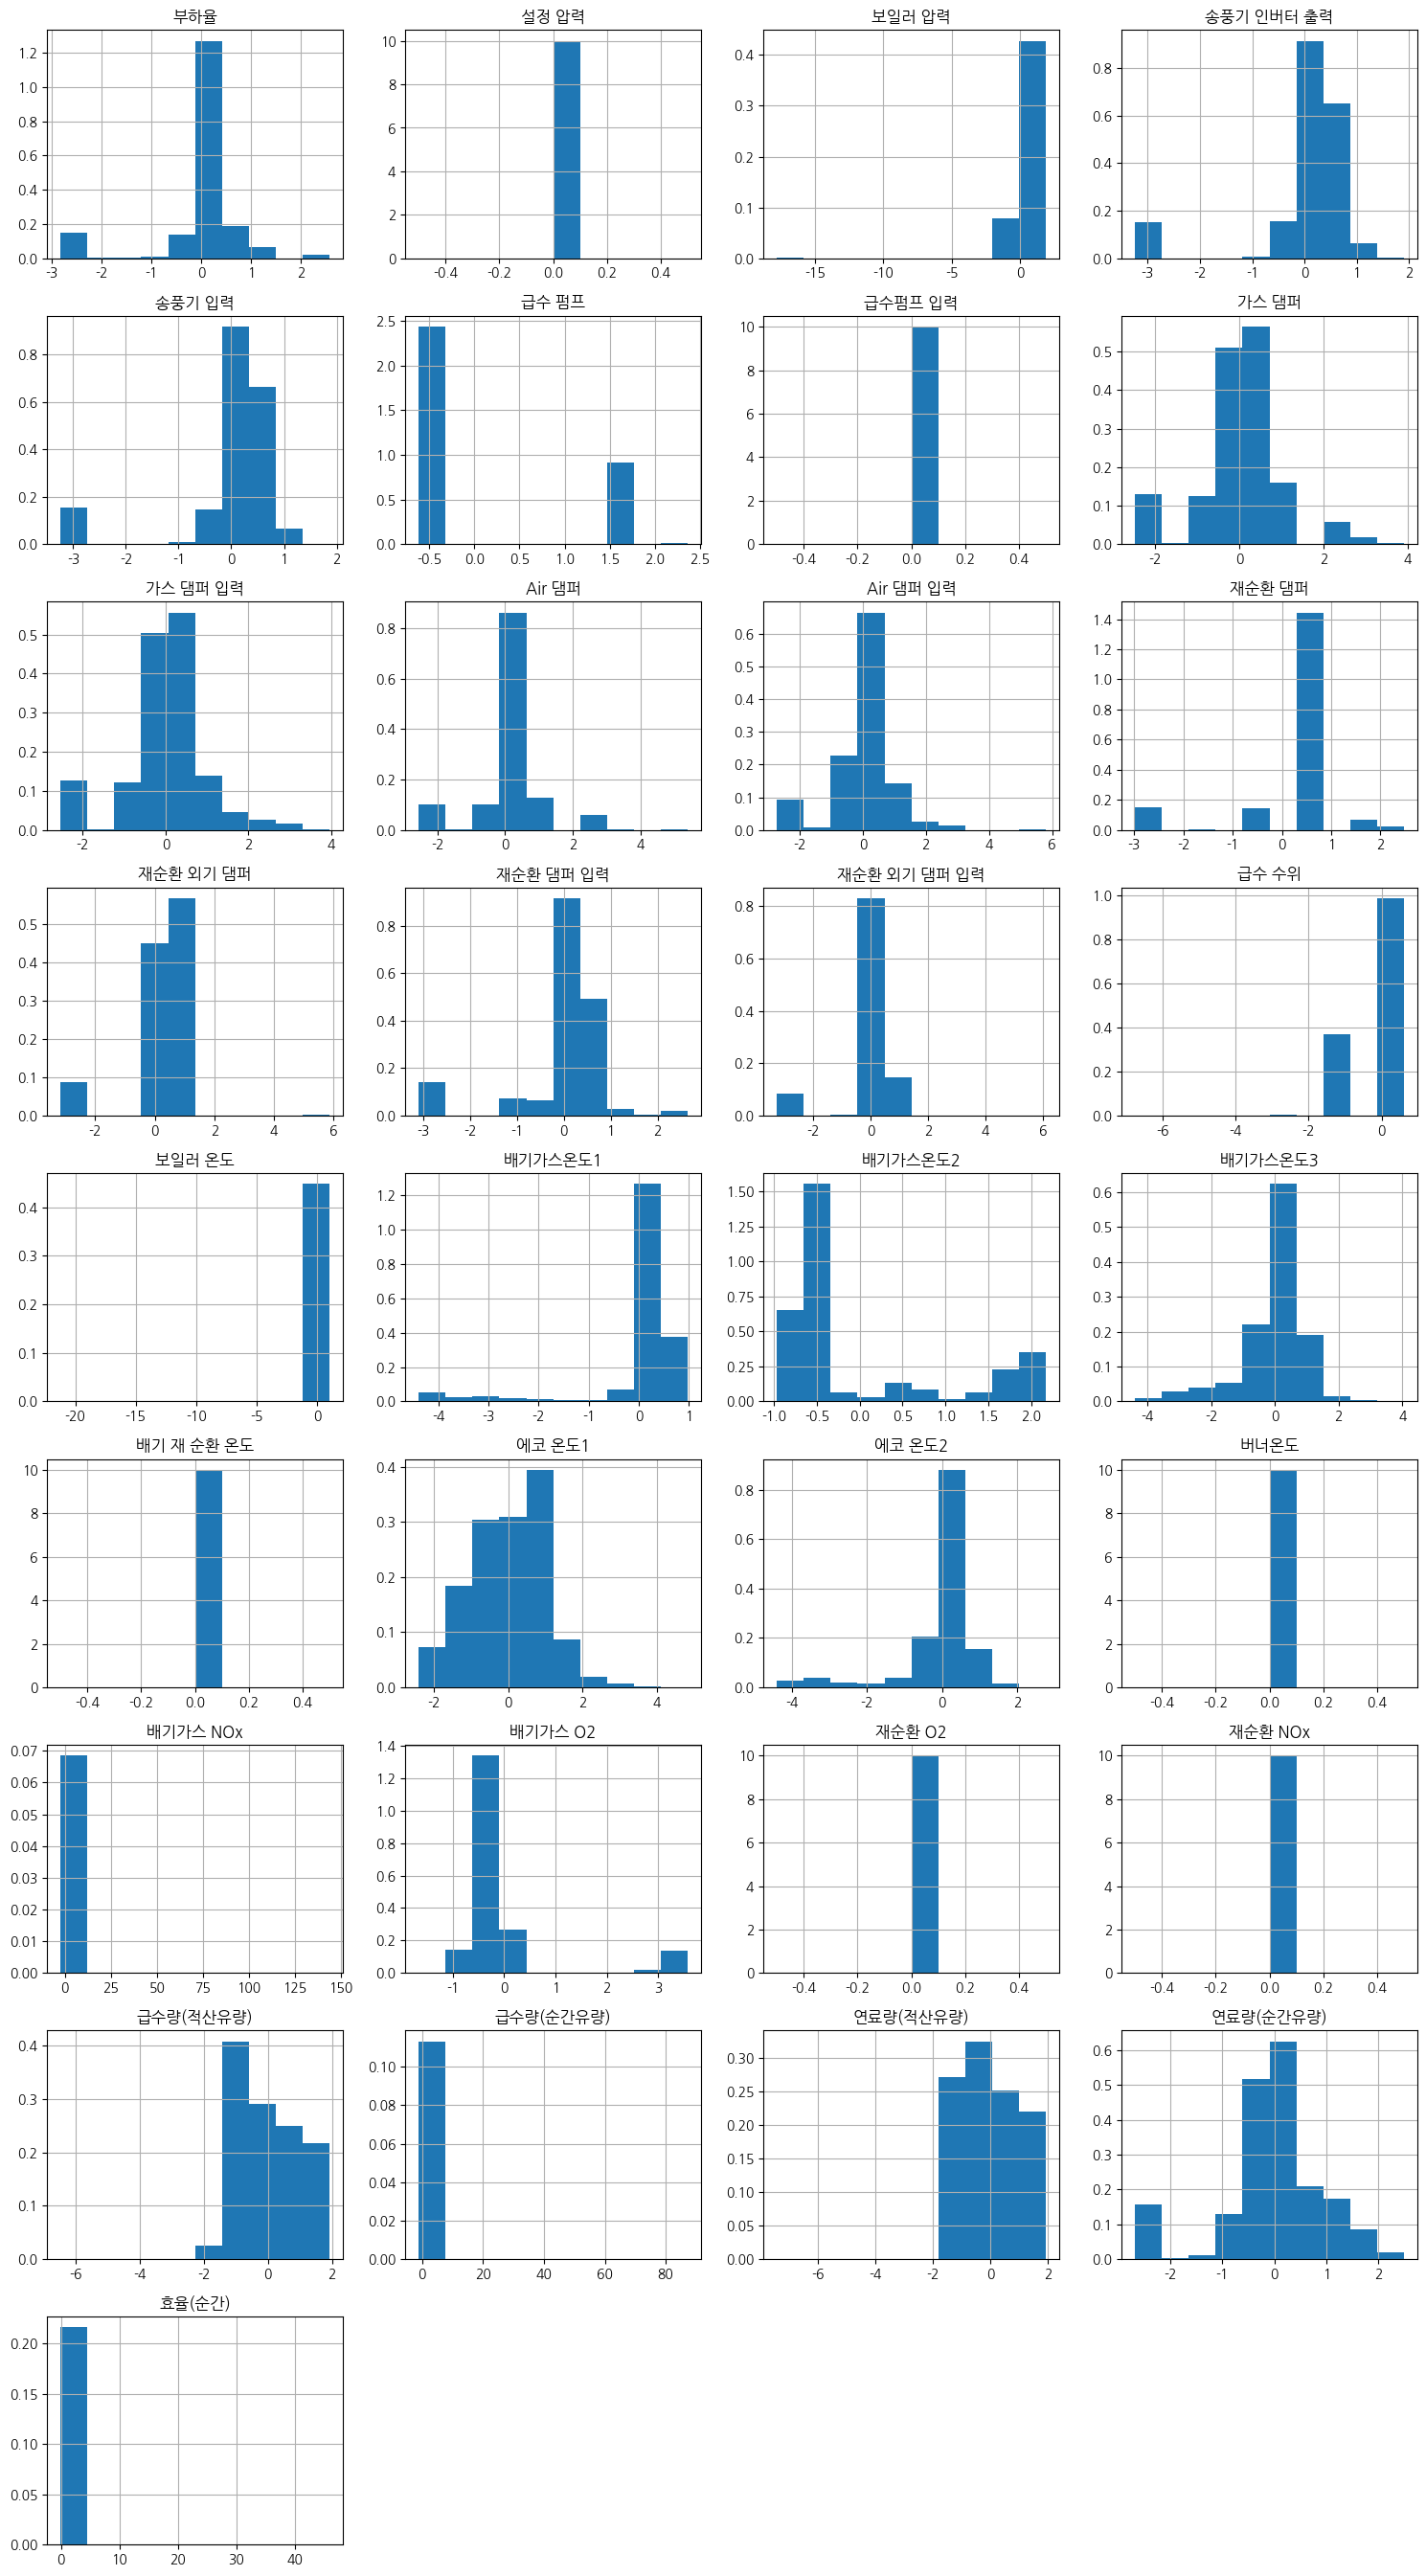

In [9]:
# Display the data types of each column in the DataFrame to confirm changes
print(combined_df.dtypes)

# Identify object type columns
object_cols = combined_df.select_dtypes(include=['object']).columns

# Convert object type columns to numeric, coercing errors to NaN
for col in object_cols:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

# Get the number of columns in the DataFrame
n_cols = len(combined_df.columns)

# Calculate the number of rows needed for subplots (4 columns per row)
n_rows = (n_cols + 3) // 4

# Create a figure and a set of subplots
fig = plt.figure(figsize=(15, 3*n_rows))

# Iterate through each column and create a histogram
for i, col in enumerate(combined_df.columns, 1):
    plt.subplot(n_rows, 4, i)
    # Drop NaN values for plotting, as hist() cannot handle them
    combined_df[col].dropna().hist(density=True)
    plt.title(col)

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()

# Display the plots
plt.show()

In [6]:
# separate features and target
y_col = '효율(순간)'
X = combined_df.drop(columns=[y_col])
y = combined_df[y_col]


# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

## XGBoost Model

In [7]:
!pip install xgboost

In [8]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set hyperparameter distribution
param_dist = {
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': np.arange(3, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1)
}

# Configure Randomized Search
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of combinations to try
    scoring='neg_mean_squared_error',
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Run Randomized Search
random_search.fit(X_train, y_train)

# Print best parameters
print("Best hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hyperparameters: {'subsample': np.float64(0.7), 'n_estimators': np.int64(400), 'max_depth': np.int64(8), 'learning_rate': 0.05, 'colsample_bytree': np.float64(0.7999999999999999)}


In [7]:
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize XGBoost model with best hyperparameters from Randomized Search
xgb_model = XGBRegressor(
    objective='reg:squarederror', # Added objective
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.7, # Subsample ratio of the training instances
    colsample_bytree=0.7999999999999999, # Subsample ratio of columns when constructing each tree
    random_state=42 # For reproducibility
)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# 모델 평가 (Model Evaluation)
print("Train R2:", xgb_model.score(X_train, y_train))
print("Test R2:", xgb_model.score(X_test, y_test))

# Calculate and print Mean Squared Error (MSE)
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("\nTrain MSE:", train_mse)
print("Test MSE:", test_mse)

# Calculate and print Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\nTrain MAE:", train_mae)
print("Test MAE:", test_mae)

# Calculate and print Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print("\nTrain RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

# Calculate and print Mean Absolute Percentage Error (MAPE)
# Avoid division by zero for MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Calculate percentage error only for non-zero true values
    non_zero_mask = y_true != 0
    if np.sum(non_zero_mask) == 0:
        return np.nan # Return NaN if no non-zero true values to avoid division by zero in mean
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100


train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print("\nTrain MAPE:", train_mape)
print("Test MAPE:", test_mape)


# show most important features (특성 중요도 표시)
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by="importance", ascending=False)

print(importance.head(10))

Train R2: 0.9995507790722546
Test R2: 0.9972541951944924

Train MSE: 0.00044763681453320305
Test MSE: 0.0027845345670523343

Train MAE: 0.0011632567813618213
Test MAE: 0.0015418406368320446

Train RMSE: 0.021157429298787767
Test RMSE: 0.05276868926790142

Train MAPE: 0.9580324797387151
Test MAPE: 1.2323524889490234
       feature  importance
3   송풍기 인버터 출력    0.227638
15       급수 수위    0.224691
31   연료량(순간유량)    0.178769
24    배기가스 NOx    0.078263
5        급수 펌프    0.075636
29   급수량(순간유량)    0.057541
9       Air 댐퍼    0.042250
17     배기가스온도1    0.041712
12   재순환 외기 댐퍼    0.017674
30   연료량(적산유량)    0.010275


In [17]:
!apt-get -y install fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


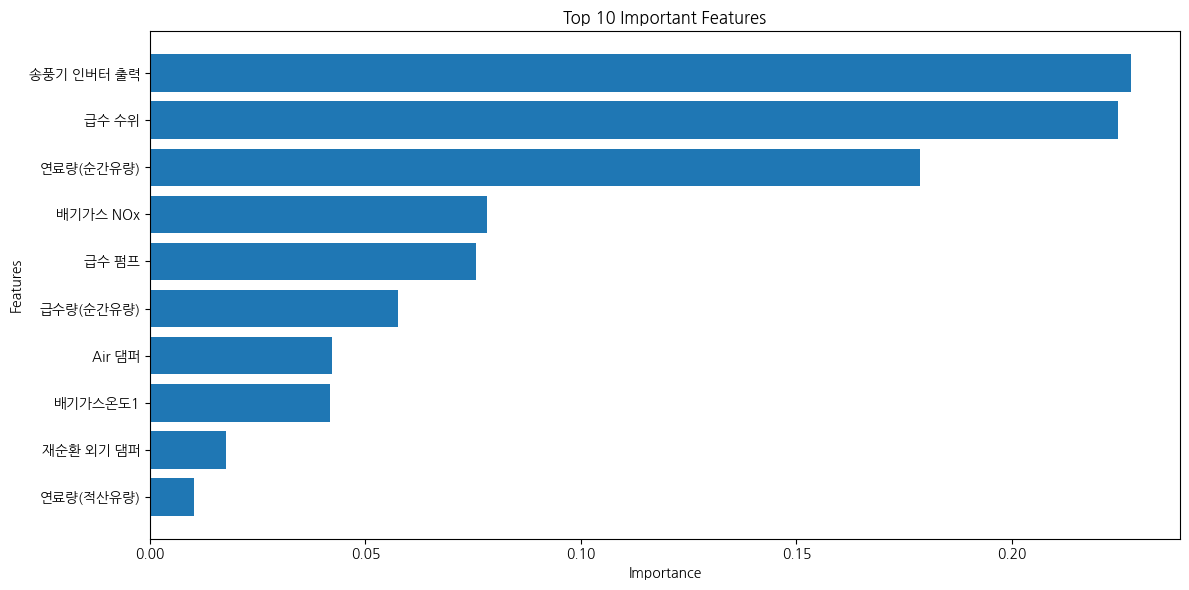

In [8]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 한글 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)  # 음수 부호 깨짐 방지

# Select the top 10 important features (or adjust the number as needed)
top_n = 10
top_features = importance.head(top_n).iloc[::-1] # Reverse the order

# Create a horizontal bar plot
plt.figure(figsize=(12, 6))
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top {} Important Features'.format(top_n))
plt.tight_layout()
plt.show()